In [1]:
import functools as ft

import pandas as pd
import numpy as np
import scipy.stats as ss
import swifter
from gvs_ab import gvs_ab as ab

import pandahouse

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

rng = np.random.default_rng()

# Задача 1

Коллеги из ML отдела предложили новый алгоритм:
- добавляет пользователям 1-2 просмотра
- вероятность работоспособности 90%
- если у пользователя меньше 50 просмотров, то алгоритм не сработает

Можно ли задетектить разницу в лайках с помощью t-test с поправкой Уэлча?
Надо Монте-Карлить!

План
- Есть данные по AA-тестам за '2024-02-23'-'2024-02-29'
- Выгрузить данные по пользователям, полагая что по ним можно строить актуальную модель
- Сымитируем эффект алгоритма на просмотры: 
    - views + (1 + Binomial(1, 0.5, size=n)) * Binomial(1, 0.9, size=n) * (views >= 50)
- Разобьём весь трафик на 2 группы
- Проведём симуляции, используя t-тест
- Уровень значимости 0.05.

#### Достаём данные

In [2]:
# Подключение к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 
    'user': 'student',
    'database': 'simulator'
}
db='simulator_20240320'

In [3]:
date_start = "toDate('2024-02-23')"
date_end = "toDate('2024-02-29')"

q = f"""
WITH 
filtered_data AS (
    SELECT
        user_id,
        time,
        exp_group,
        action
    FROM {db}.feed_actions
    WHERE 
        time>={date_start} AND time<{date_end}+1
),
feed_actions AS (
    -- Активность пользователей из интересующих групп за указанный период
    SELECT
        user_id,
        countIf(time, action='like') AS likes,
        countIf(time, action='view') AS views,
        likes/views as ctr
    FROM filtered_data
    GROUP BY user_id
)

SELECT *
FROM feed_actions
"""

df = pandahouse.read_clickhouse(q, connection=connection)
df

,user_id,likes,views,ctr
0,13289,2,32,0.062500
1,121096,12,57,0.210526
2,5090,2,14,0.142857
3,129283,23,80,0.287500
4,4394,25,54,0.462963
...,...,...,...,...
41992,3795,3,17,0.176471
41993,123954,23,101,0.227723
41994,124666,32,141,0.226950
41995,11280,29,133,0.218045


#### Строим модель

In [4]:
# Классы для генерирования правдоподобных данных

class DataSimulator:
    '''Источник симулированных данных для формирования синтетических выборок'''
    
    def __init__(self, views, ctr):
        '''
        Запись исходных данных
        
        views: np.array-like
        ctr: np.array-like
        '''
        self._views = views
        self._ctr = ctr
        self._n_init = views.shape[0]
        
    def create_group(self,
        group_name,
        views_dif=lambda x: x,
        likes_dif=lambda x: x,
        ctr_dif=lambda x: x
    ):
        '''
        Создание группы (контрольной/тестовой)

        group_name: str
        views_dif: callable, default lambda x: x
            Изменение просмотров
        likes_dif: callable, default lambda x: x
            Изменение лайков
        ctr_dif: callable, default lambda x: x
            Изменение ctr
        '''
        group = Group(
            sim=self,
            group_name=group_name,
            views_dif=views_dif,
            likes_dif=likes_dif,
            ctr_dif=ctr_dif
        )
        self.__dict__.update({group_name: group})


class Group:
    '''Контрольная/тестовая группа'''
    
    def __init__(self, 
        sim,
        group_name,
        views_dif,
        likes_dif,
        ctr_dif
):      
        '''
        Создание группы
        
        sim: DataSimulator
            Источник данных (опорных распределений)
        group_name: str
            Название группы
        views_dif: callable, default lambda x: x
            Изменение просмотров
        likes_dif: callable, default lambda x: x
            Изменение лайков
        ctr_dif: callable, default lambda x: x
            Изменение ctr
        '''
        self._sim = sim
        self._group_name = group_name
        self._views_dif = views_dif
        self._likes_dif = likes_dif
        self._ctr_dif = ctr_dif
        self.views = np.array([])
        self._ctr_medium = np.array([])
        self.ctr = np.array([])
        self.likes = np.array([])
        
        
    def rvs(self, n_simulations, sample_size):
        '''
        Генерация выборки
        
        n_simulations: int
            Количество симуляций
        sample_size: int
            Размер выборки
        '''
        self.views = rng.choice(
            self._views_dif(self._sim._views), 
            size=(n_simulations, sample_size), 
            replace=True).astype('int32')
        self._ctr_medium = rng.choice(
            self._ctr_dif(self._sim._ctr), 
            size=(n_simulations, sample_size), 
            replace=True)

        self.likes = rng.binomial(self.views, self._ctr_medium)
        self.likes = self._likes_dif(self.likes)
        
        self.ctr = self.likes / self.views

In [5]:
date_start = "toDate('2024-02-23')"
date_end = "toDate('2024-02-29')"

q = f"""
WITH 
filtered_data AS (
    SELECT
        user_id,
        toDate(time) AS date,
        action
    FROM {db}.feed_actions
    WHERE time>={date_start} AND time<{date_end}+1
),
feed_actions AS (
    -- Активность пользователей из интересующих групп за указанный период
    SELECT
        user_id,
        date,
        FLOOR(sum(action='like') / sum(action='view'), 2) as ctr
    FROM filtered_data
    GROUP BY date, user_id
)

SELECT *
FROM feed_actions
"""

ctr_df = pandahouse.read_clickhouse(q, connection=connection)
ctr_df

,user_id,date,ctr
0,128456,2024-02-27,0.15
1,7977,2024-02-27,0.17
2,121097,2024-02-24,0.12
3,5091,2024-02-24,0.00
4,107322,2024-02-28,0.16
...,...,...,...
85116,116978,2024-02-27,0.20
85117,3098,2024-02-24,0.23
85118,21738,2024-02-28,0.19
85119,122191,2024-02-25,0.16


all views: 41997
sample size: 20998


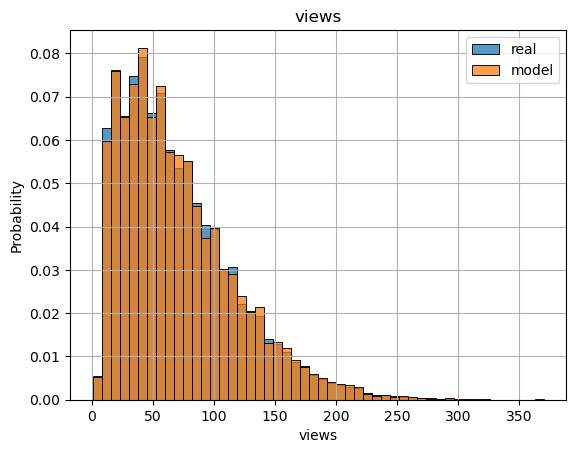

In [6]:
# Объект - симулятор данных
sim = DataSimulator(df.views, df.ctr)

# Генерация контрольной выборки
sample_size = int(df.views.shape[0] / 2)
sim.create_group('a')
sim.a.rvs(1, sample_size)

# Проверка
bins=50
sns.histplot(
    df.views,
    bins=bins,
    stat='probability',
    label='real'
);
sns.histplot(
    sim.a.views.flatten(),
    bins=bins,
    stat='probability',
    label='model'
);
plt.title('views');
plt.legend()
plt.grid();

print(f'all views: {df.views.shape[0]}\nsample size: {sample_size}')

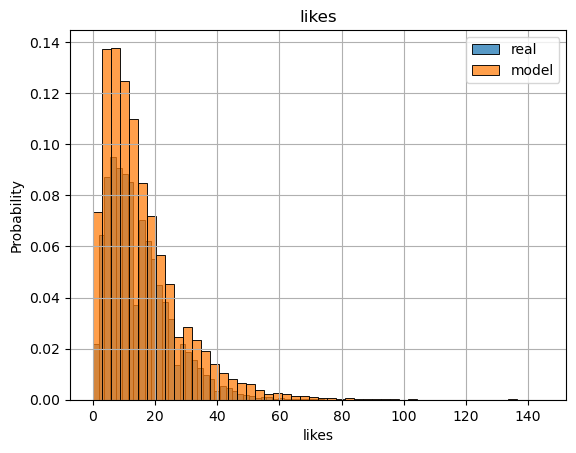

In [7]:
# Проверка
bins=50
sns.histplot(
    df.likes,
    bins=bins,
    stat='probability',
    label='real'
);
sns.histplot(
    sim.a.likes.flatten(),
    bins=bins,
    stat='probability',
    label='model'
);
plt.title('likes');
plt.legend()
plt.grid();

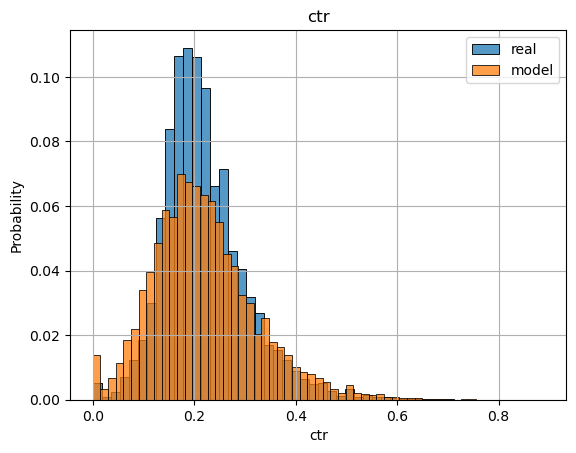

In [8]:
# Проверка
bins=50
sns.histplot(
    df.ctr,
    bins=bins,
    stat='probability',
    label='real'
);
sns.histplot(
    sim.a.ctr.flatten(),
    bins=bins,
    stat='probability',
    label='model'
);
plt.title('ctr');
plt.legend()
plt.grid();

In [9]:
# AA тест
def simulation():  # Для экономии оперативы (???)
    n_simulations = 1000
    sample_size = int(df.views.shape[0] / 2)
    alpha = 0.05
    
    # Создание групп
    sim = DataSimulator(df.views, ctr_df.ctr)
    sim.create_group('a')
    sim.create_group('b')
    # Генерация выборок
    sim.a.rvs(n_simulations, sample_size)
    sim.b.rvs(n_simulations, sample_size)

    # Тесты
    pvals = ab.func_for_mtx_rows(
        ss.ttest_ind,
        sim.a.likes,
        sim.b.likes,
        cur_func_res_idx=1,
        cur_func_print_info=True,
        equal_var=False
    )
    fpr = (pvals < alpha).sum() / n_simulations
    
    print(fpr)
    
simulation()
# Роботает

0it [00:00, ?it/s]

0.04


In [10]:
# Тестовая выборка
views_dif = lambda x: (
    x + 
    (1 + np.random.binomial(1, 0.5, size=x.size))
    * np.random.binomial(1, 0.9, size=x.size)
    * (x >= 50)
)

sim.create_group(
    group_name='b',
    views_dif=views_dif
)

In [11]:
# Проверка внедрения изменений
n_simulations = 500

sim.a.rvs(n_simulations, sample_size)
sim.b.rvs(n_simulations, sample_size)


print(f'views mean dif: {sim.b.views.mean() - sim.a.views.mean()}')

views mean dif: 0.7958370320982908


In [12]:
# Мощность t-testa с поправкой Уэлча
def simulation():  # Для экономии оперативы (???)
    n_simulations = 1000
    sample_size = int(df.views.shape[0] / 2)
    alpha = 0.05
    
    # Создание групп
    sim = DataSimulator(df.views, ctr_df.ctr)
    sim.create_group('a')
    sim.create_group('b', views_dif=views_dif)
    # Генерация выборок
    sim.a.rvs(n_simulations, sample_size)
    sim.b.rvs(n_simulations, sample_size)

    # Тесты
    pvals = ab.func_for_mtx_rows(
        ss.ttest_ind,
        sim.a.likes,
        sim.b.likes,
        cur_func_res_idx=1,
        cur_func_print_info=True,
        equal_var=False
    )
    power = (pvals < alpha).sum() / n_simulations
    
    print(power)
    
simulation()

0it [00:00, ?it/s]

0.262


Поразительно низкий показатель

Ф

In [13]:
def power_calc(sample_size, views_df, ctr_df, threshold, nsim=1000):
    """
    Считает мощность для t-теста при заданных параметрах распределения и эффекта
    :param sample_size: размер выборок
    :param views_df: датафрейм со значениями просмотров и их вероятностями
    :param ctr_df: датафрейм со значениями прользовательских CTR и их вероятностями
    :param threshold: порог просмотров, после которого начинает действовать алгоритм
    :param nsim: количество симуляций (по умолчанию 1000)
    :return: значение мощности от 0 до 1
    """

    pvalues = [] #список, куда мы будем складывать p-value
    rng = np.random.default_rng() #генератор случайных чисел

    #симуляируем и сравниваем выборки nsim раз:

    for _ in tqdm(range(nsim)):

        #симулируем просмотры
        group_A_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")
        group_B_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")

        #симулируем эффект в тестовой группе
        group_B_views = group_B_views + (rng.binomial(n=1, p=0.9, size=sample_size) * (1 + rng.binomial(n=1, p=0.5, size=sample_size)) * (group_B_views >= threshold))
        group_B_views = group_B_views.astype("int64")

        #симулируем CTR
        group_A_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)
        group_B_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)

        #симулируем лайки
        clicks_A = rng.binomial(n=group_A_views, p=group_A_ctr)
        clicks_B = rng.binomial(n=group_B_views, p=group_B_ctr)

        #сравниваем t-тестом и сохраняем p-value
        pvalues.append(ss.ttest_ind(clicks_A, clicks_B, equal_var=False).pvalue)

    #возвращаем мощность
    return np.mean(np.array(pvalues) < 0.05)

In [14]:
col = 'views'
views_distribution = (
    df[col].value_counts(normalize=True)
    .to_frame('values').reset_index()
    .rename(columns={'index': col, 'values': 'p'})
)
views_distribution

,views,p
0,16,0.012977
1,15,0.012787
2,14,0.011906
3,35,0.011548
4,30,0.011167
...,...,...
296,320,0.000024
297,254,0.000024
298,326,0.000024
299,270,0.000024


In [15]:
col = 'ctr'
ctr_distribution = (
    ctr_df[col].value_counts(normalize=True)
    .to_frame('values').reset_index()
    .rename(columns={'index': col, 'values': 'p'})
)
ctr_distribution.sort_values('ctr')

,ctr,p
23,0.00,0.016952
54,0.02,0.000564
46,0.03,0.001668
39,0.04,0.003665
33,0.05,0.008541
...,...,...
75,0.81,0.000023
79,0.83,0.000012
72,0.85,0.000035
77,0.88,0.000012


In [16]:
power_calc(sample_size=20998, views_df=views_distribution, ctr_df=ctr_distribution, threshold=50, nsim=1000)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.61it/s]


0.287

---------------------
# Задание 2
Коллеги улучшили алгоритм. Теперь он срабатывает на пользователях с числом просмотров от 30 и выше.

In [17]:
# Тестовая выборка
views_dif = lambda x: (
    x + 
    (1 + np.random.binomial(1, 0.5, size=x.size))
    * np.random.binomial(1, 0.9, size=x.size)
    * (x >= 30)
)

In [18]:
# Мощность t-testa с поправкой Уэлча
def simulation():  # Для экономии оперативы (???)
    n_simulations = 10000
    sample_size = int(df.views.shape[0] / 2)
    alpha = 0.05
    
    # Создание групп
    sim = DataSimulator(df.views, ctr_df.ctr)
    sim.create_group('a')
    sim.create_group('b', views_dif=views_dif)
    # Генерация выборок
    sim.a.rvs(n_simulations, sample_size)
    sim.b.rvs(n_simulations, sample_size)

    # Тесты
    pvals = ab.func_for_mtx_rows(
        ss.ttest_ind,
        sim.a.likes,
        sim.b.likes,
        cur_func_res_idx=1,
        cur_func_print_info=True,
        equal_var=False
    )
    power = (pvals < alpha).sum() / n_simulations
    
    print(power)
    
simulation()

0it [00:00, ?it/s]

0.4158


Стало не сильно лучше

----------------
# Задание 3
Утвердили длительность эксперимента длиной в 2 недели. 

Пришло столько же пользователей, сколько за период AA ('2024-02-23'-'2024-02-29') и AB ('2024-03-01' - '2024-03-07') теста

In [19]:
date_start = ""
date_end = ""

q = f"""
WITH 
filtered_data AS (
    SELECT
        user_id,
        toDate(time) AS date
    FROM {db}.feed_actions
    WHERE 
        date BETWEEN toDate('2024-02-23') AND toDate('2024-02-29')
        OR date BETWEEN toDate('2024-03-01') AND toDate('2024-03-07')
)

SELECT COUNT(DISTINCT user_id) AS users
FROM filtered_data
"""

n_users = pandahouse.read_clickhouse(q, connection=connection).users.values[0]
n_users

61182

In [20]:
# Тестовая выборка
views_dif = lambda x: (
    x + 
    (1 + np.random.binomial(1, 0.5, size=x.size))
    * np.random.binomial(1, 0.9, size=x.size)
    * (x >= 30)
)

In [21]:
sample_size = int(n_users / 2)
sample_size

30591

Выборка увеличилась в ~1.5 раза

In [22]:
# Мощность t-testa с поправкой Уэлча
n_simulations = 10000
sample_size = int(n_users / 2)
alpha = 0.05

# Создание групп
sim = DataSimulator(df.views, ctr_df.ctr)
sim.create_group('a')
sim.create_group('b', views_dif=views_dif)
# Генерация выборок
sim.a.rvs(n_simulations, sample_size)
sim.b.rvs(n_simulations, sample_size)

# Тесты
pvals = ab.func_for_mtx_rows(
    ss.ttest_ind,
    sim.a.likes,
    sim.b.likes,
    cur_func_res_idx=1,
    cur_func_print_info=True,
    equal_var=False
)
power = (pvals < alpha).sum() / n_simulations
    
power

0it [00:00, ?it/s]

0.5628

Уже лучше

------------
# Задача 4
Что если в выборку будем брать только пользователей, которых могло затронуть изменение?

In [23]:
sample_size

30591

In [31]:
def power_calc(sample_size, views, ctr, threshold, nsim=1000):
    pvalues = [] #список, куда мы будем складывать p-value
    rng = np.random.default_rng() #генератор случайных чисел

    #симуляируем и сравниваем выборки nsim раз:

    for _ in tqdm(range(nsim)):

        #симулируем просмотры
        group_A_views = rng.choice(a=views, size=sample_size, replace=True).astype("int64")
        group_B_views = rng.choice(a=views, size=sample_size, replace=True).astype("int64")

        mask_A = group_A_views >= threshold
        mask_B = group_B_views >= threshold
        
        #симулируем эффект в тестовой группе
        group_B_views = group_B_views + rng.binomial(n=1, p=0.9, size=sample_size) * (1 + rng.binomial(n=1, p=0.5, size=sample_size)) * mask_B
        group_B_views = group_B_views.astype("int64")

        #симулируем CTR
        group_A_ctr = rng.choice(a=ctr, size=sample_size, replace=True)
        group_B_ctr = rng.choice(a=ctr, size=sample_size, replace=True)

        #симулируем лайки
        clicks_A = rng.binomial(n=group_A_views, p=group_A_ctr)
        clicks_B = rng.binomial(n=group_B_views, p=group_B_ctr)
        
        

        #сравниваем t-тестом и сохраняем p-value
        pvalues.append(ss.ttest_ind(clicks_A[mask_A], clicks_B[mask_B], equal_var=False).pvalue)

    #возвращаем мощность
    return np.mean(np.array(pvalues) < 0.05)

In [32]:
power_calc(sample_size, df.views, ctr_df.ctr, threshold=30, nsim=10000)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:22<00:00, 120.88it/s]


0.6421

-----------
# Выводы:
Положительно влияет на мощность:
- больший MDE
- больший размер выборки
- меньший шум (сравнивать целевые квантили)